In [1]:
import json
import numpy as np
from domain_objects import GameParams, NewAgent
from new_guessing_game import RandomFunctions, run_simulation, new_random_f, select_speaker, select_hearer, avg_series
from calculator import NumericCalculator, QuotientCalculator, Calculator


In [2]:
population_size=6
stimulus='quotient'
max_num=100
discriminative_threshold=0.95
discriminative_history_length=50
delta_inc=0.2
delta_dec=0.2
delta_inh=0.2
alpha=0.001
super_alpha=0.01
beta=0.2
steps=3100
runs=1
guessing_game_2=False
seed=0

params = GameParams(population_size=population_size,
               stimulus=stimulus,
               max_num=max_num,
               discriminative_threshold=discriminative_threshold,
               discriminative_history_length=50,
               delta_inc=delta_inc,
               delta_dec=delta_dec,
               delta_inh=delta_inh,
               alpha=alpha,
               super_alpha=super_alpha,
               beta=beta,
               steps=steps,
               runs=runs,
               guessing_game_2=guessing_game_2,
               seed=seed)


In [3]:
r = next(new_random_f(seed=params.seed))
agg_cs1 = []
agg_ds = []
calculator = {'numeric': NumericCalculator.load_from_file(),
                  'quotient': QuotientCalculator.load_from_file()}[params.stimulus]
population, states_sequences, states_edges_cnts, states_cnts = run_simulation(calculator, params, r.shuffle_list_random_function(), r.flip_a_coin_random_function(), r.pick_element_random_function())

windowed_communicative_success1 = np.array([avg_series(a.get_communicative_success1()) for a in population])*100
windowed_communicative_success2 = [avg_series(a.get_communicative_success2()) for a in population]
windowed_discriminative_success = np.array([avg_series(a.get_discriminative_success()) for a in population])*100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3100/3100 [00:05<00:00, 526.41it/s]


In [4]:
averaged_windowed_communicative_success1 = np.mean(windowed_communicative_success1, axis=0)
averaged_windowed_discriminative_success = np.mean(windowed_discriminative_success, axis=0)

# Analysis & Visualizations

## Single Agent Analysis

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from plot_utils import plot_category


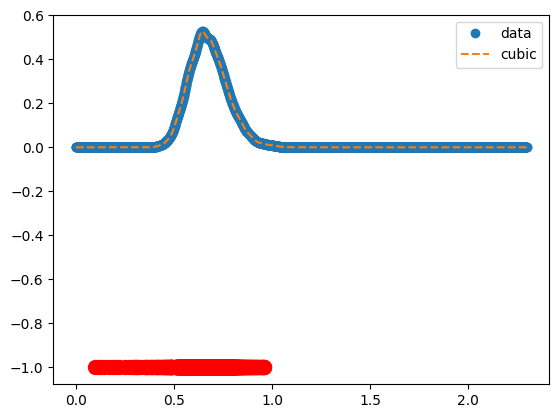

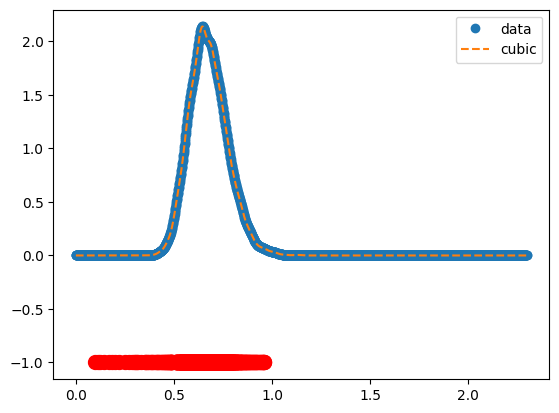

In [6]:
agent = population[0]
#agent_dict = NewAgent.to_dict(population[0])
#json.dumps(NewAgent.to_dict(population[0]))
meanings = agent.compute_word_meanings(calculator=calculator)
word, semantic_meanings = list(meanings.items())[1]
semantic_meanings = [round(num/denum,3) for num, denum in semantic_meanings]
c = agent.get_most_connected_category(word)
plot_category(c, semantic_meanings, calculator)
originated_from = word.originated_from_category
plot_category(originated_from, semantic_meanings, calculator)


In [11]:
agent = population[0]
recreated_agent = NewAgent.recreate_from_history(agent_id=agent.agent_id, calculator=calculator, game_params=params, updates_history=agent.updates_history,
                                                 step=15)
agent_dict = NewAgent.to_dict(recreated_agent[-1])
lxc = np.array(agent_dict['lxc'])

sns.set()
ax = sns.heatmap(lxc, vmin=0, vmax=1, cmap="crest")
plt.show()

recreating agent 2 by updates: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 960.25it/s]


AssertionError: after deletion column vectors correspond to categories in 1-1 manner

## Population Statistics

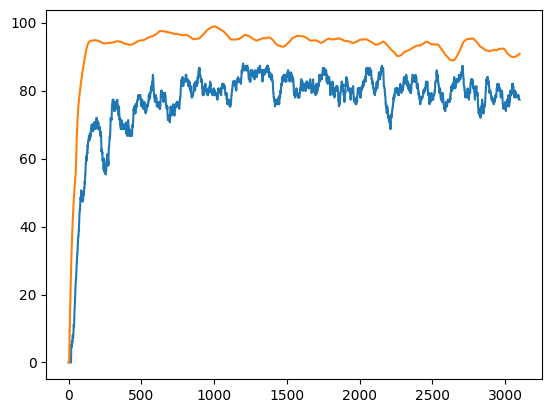

In [8]:
plt.plot(range(len(averaged_windowed_communicative_success1)), averaged_windowed_communicative_success1)
plt.plot(range(len(averaged_windowed_discriminative_success)), averaged_windowed_discriminative_success)

plt.show()


In [18]:
meanings = agent.get_word_meanings(calculator=calculator)
for w, stimuli in meanings.items():
    print(w, w.originated_from_category)
    print([round(num / denum, 3) for num, denum in w.originated_from_category.reactive_units()])
    print([round(num/denum, 3) for num, denum in stimuli])

NewWord(word_id=5, originated_from_category=[[2.0624749538746636]x[(11, 71)]]) [[2.0624749538746636]x[(11, 71)]]
[0.155]
[0.01, 0.01, 0.01, 0.01, 0.01, 0.011, 0.011, 0.011, 0.011, 0.011, 0.011, 0.011, 0.011, 0.011, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.013, 0.013, 0.013, 0.013, 0.013, 0.013, 0.014, 0.014, 0.014, 0.014, 0.014, 0.014, 0.015, 0.015, 0.015, 0.015, 0.016, 0.016, 0.016, 0.016, 0.017, 0.017, 0.017, 0.018, 0.018, 0.018, 0.019, 0.019, 0.019, 0.02, 0.02, 0.02, 0.02, 0.021, 0.021, 0.021, 0.021, 0.022, 0.022, 0.022, 0.022, 0.022, 0.023, 0.023, 0.023, 0.024, 0.024, 0.024, 0.024, 0.025, 0.025, 0.025, 0.026, 0.026, 0.026, 0.027, 0.027, 0.027, 0.028, 0.028, 0.029, 0.029, 0.029, 0.03, 0.03, 0.03, 0.031, 0.031, 0.031, 0.031, 0.032, 0.032, 0.032, 0.032, 0.033, 0.033, 0.033, 0.033, 0.034, 0.034, 0.034, 0.034, 0.035, 0.035, 0.035, 0.036, 0.036, 0.036, 0.037, 0.037, 0.037, 0.038, 0.038, 0.038, 0.039, 0.039, 0.039, 0.04, 0.04, 0.041, 0.041, 0.041, 0.041, 0.042, 0.042, 0.042, 0.043, 0.0